In [1]:
from keras.layers import Input
from keras.optimizers import SGD,Adam,RMSprop
from keras.layers import Bidirectional
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer=Tokenizer()

Using TensorFlow backend.


In [2]:
corpus=[]
for line in open('data2.txt','r').readlines():
    corpus.append(line.strip())

tokenizer.fit_on_texts(corpus)
sequences=tokenizer.texts_to_sequences(corpus)

data_oh=pad_sequences(sequences=sequences,maxlen=50,padding='post')   #最大长度为50，以post的方式补全

#导入数据，对案件类型分类
filepath='C:/Users/zhangsheng/Desktop/DSjjcl/version2/new_all_df.csv'    #原始数据 
all_df=pd.read_csv(filepath,encoding='gb18030')

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
labEn=LabelEncoder()

all_df['案件类型']=labEn.fit_transform(all_df['案件类型'])
new_df=all_df[['案件类型']]

all_labels=new_df.values

In [3]:
word_index=tokenizer.word_index
Embedding_dim=200
max_length=50

In [4]:
from keras.utils import to_categorical

labels=to_categorical(all_labels)

In [5]:
#分割数据  8:2的比例  随机
msk=np.random.rand(len(new_df))<0.8
train=new_df[msk]
test=new_df[~msk]

index=train.index
x_train=data_oh[index][0:40000]
x_val=data_oh[index][40000:]

# y_train=train.values[0:40000]
# y_val=train.values[40000:]
y_train=labels[index][0:40000]
y_val=labels[index][40000:]

test_index = test.index
x_test = data_oh[test_index]
y_test=labels[test_index]

In [9]:
from keras.layers import Dense,Input,Flatten,Dropout,LSTM,Embedding
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv1D,MaxPool1D

In [9]:
#CNN
from keras.layers import Conv1D,MaxPool1D
CNN_model=Sequential()
CNN_model.add(Embedding(input_dim=len(word_index)+1,output_dim=200,input_length=50))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
CNN_model.add(MaxPool1D(3))
CNN_model.add(Flatten())
CNN_model.add(Dense(Embedding_dim,activation='relu'))
CNN_model.add(Dense(3,activation='softmax'))
CNN_model.summary()

CNN_model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=["accuracy"])
CNN_model.fit(x_train,y_train,validation_data=[x_val,y_val],epochs=10,batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 200)           3023000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 48, 64)            38464     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               205000    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 603       
Total para

In [14]:
CNN_predict=CNN_model.predict(x_test)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

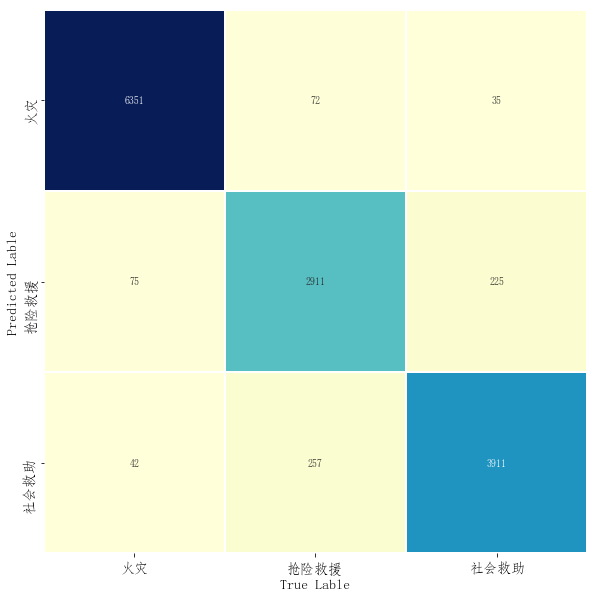

In [17]:
# CNN混淆矩阵
confm = metrics.confusion_matrix(
    np.argmax(CNN_predict, axis=1), np.argmax(y_test, axis=1))
LabName = ['火灾', '抢险救援', '社会救助']
plt.figure(figsize=(10, 10))
sns.heatmap(confm.T, square=True, annot=True, fmt='d',
            cbar=False, linewidths=.8, cmap='YlGnBu')
plt.xlabel('True Lable', size=14)
plt.ylabel('Predicted Lable', size=14)
plt.xticks(np.arange(3)+0.5, LabName, size=14)
plt.yticks(np.arange(3)+0.5, LabName, size=14)
plt.show()

In [18]:
#召回率
print(metrics.classification_report(np.argmax(CNN_predict,axis=1),np.argmax(y_test,axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6468
           1       0.91      0.90      0.90      3240
           2       0.93      0.94      0.93      4171

   micro avg       0.95      0.95      0.95     13879
   macro avg       0.94      0.94      0.94     13879
weighted avg       0.95      0.95      0.95     13879



In [7]:
##word2vec
###载入预训练好的word2vec模型，并使用该模型替代Embedding层
import gensim
from gensim.models import Word2Vec

w2v_model=Word2Vec.load('word2vec.model')
embedding_matrix=np.zeros((len(word_index)+1,Embedding_dim))
for word,i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i]=np.asarray(w2v_model[word],
                                      dtype='float32')
embedding_layer=Embedding(len(word_index)+1,
                         Embedding_dim,   #输出维度应该=预训练的size大小
                         weights=[embedding_matrix],
                         input_length=max_length,
                         trainable=False)

d:\python3.6\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
d:\python3.6\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
d:\python3.6\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [10]:
CNN_w2v_model=Sequential()
CNN_w2v_model.add(embedding_layer)
CNN_w2v_model.add(Dropout(0.2))
CNN_w2v_model.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
CNN_w2v_model.add(MaxPool1D(3))
CNN_w2v_model.add(Flatten())
CNN_w2v_model.add(Dense(Embedding_dim,activation='relu'))
CNN_w2v_model.add(Dense(3,activation='softmax'))
CNN_w2v_model.summary()

CNN_w2v_model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=["accuracy"])
CNN_w2v_model.fit(x_train,y_train,validation_data=[x_val,y_val],epochs=10,batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 200)           3023000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 64)            38464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total para

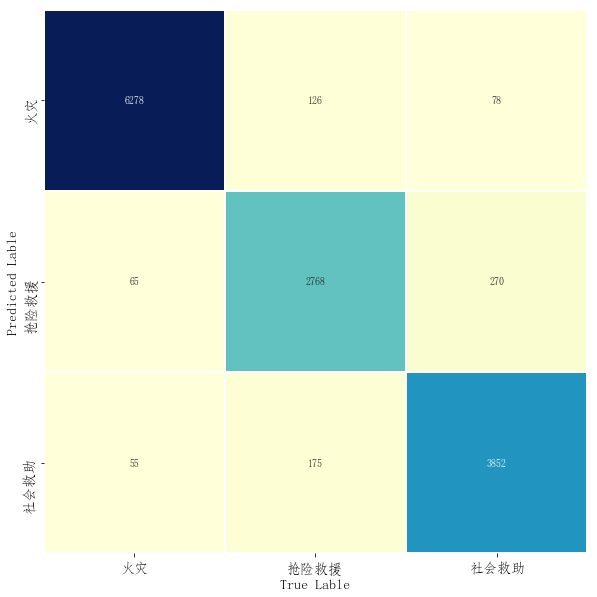

In [13]:
CNN_w2v_predict=CNN_w2v_model.predict(x_test)
# CNN_w2v混淆矩阵
confm = metrics.confusion_matrix(
    np.argmax(CNN_w2v_predict, axis=1), np.argmax(y_test, axis=1))
LabName = ['火灾', '抢险救援', '社会救助']
plt.figure(figsize=(10, 10))
sns.heatmap(confm.T, square=True, annot=True, fmt='d',
            cbar=False, linewidths=.8, cmap='YlGnBu')
plt.xlabel('True Lable', size=14)
plt.ylabel('Predicted Lable', size=14)
plt.xticks(np.arange(3)+0.5, LabName, size=14)
plt.yticks(np.arange(3)+0.5, LabName, size=14)
plt.show()

In [14]:
#召回率
print(metrics.classification_report(np.argmax(CNN_w2v_predict,axis=1),np.argmax(y_test,axis=1),digits=4))

              precision    recall  f1-score   support

           0     0.9685    0.9812    0.9748      6398
           1     0.8920    0.9019    0.8970      3069
           2     0.9437    0.9171    0.9302      4200

   micro avg     0.9437    0.9437    0.9437     13667
   macro avg     0.9347    0.9334    0.9340     13667
weighted avg     0.9437    0.9437    0.9436     13667



In [ ]:
'''结论：
    1.CNN与引入w2v后的CNN相比较，准确率上并没有明显的提升
    2.引入w2v后，需要训练的参数大大减小，由300万减小为20多万，大大节省了训练时间；每个epoch的训练时间节省约15s
'''